In [1]:
# pip install -r requirements.txt

In [3]:
import warnings
warnings.filterwarnings('ignore')
import json
import pandas as pd
import re
import string
from spellchecker import SpellChecker
import json
from collections import Counter
from textstat import textstat
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.feature_selection import SelectFromModel
from transformers import T5ForConditionalGeneration, T5Tokenizer
import torch
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
from rouge import Rouge
import os
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import concatenate_datasets
import evaluate
from transformers import DataCollatorForSeq2Seq
from huggingface_hub import HfFolder
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers import pipeline
from random import randrange
from nltk.tokenize import sent_tokenize
from transformers import BartTokenizer, BartForConditionalGeneration, Trainer, TrainingArguments
from torch.utils.data import Dataset
import torch


# Download necessary NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')
# nltk.download('all')

[nltk_data] Downloading package punkt to /home/deepanshu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/deepanshu/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:
root_path = 'corpus/'
path='corpus/data-processing/'

In [5]:
# Load the dataset
with open(root_path + 'train.json', 'r', encoding='utf-8') as f:
    train_data = json.load(f)
with open(root_path + 'test.json', 'r', encoding='utf-8') as f:
    test_data = json.load(f)
with open(root_path + 'val.json', 'r', encoding='utf-8') as f:
    eval_data = json.load(f)

# Convert to DataFrames
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)
eval_df = pd.DataFrame(eval_data)

# Combine all three into one
# full_df = pd.concat([train_df, eval_df], ignore_index=True)

In [6]:
with open(root_path + 'train.json', 'r', encoding='utf-8') as f:
    processed_dialogues = json.load(f)

In [7]:
class SummaryDataset(Dataset):
    # Initialize the dataset with a tokenizer, data, and maximum token length
    def __init__(self, tokenizer, data, max_length=512):
        self.tokenizer = tokenizer  # Tokenizer for encoding text
        self.data = data            # Data containing dialogues and summaries
        self.max_length = max_length # Maximum length of tokens

    # Return the number of items in the dataset
    def __len__(self):
        return len(self.data)

    # Retrieve an item from the dataset by index
    def __getitem__(self, idx):
        item = self.data.iloc[idx]  # Get the row at the specified index
        dialogue = item['dialogue'] # Extract dialogue from the row
        summary = item['summary']   # Extract summary from the row

        # Encode the dialogue as input data for the model
        source = self.tokenizer.encode_plus(
            dialogue, 
            max_length=self.max_length, 
            padding='max_length', 
            return_tensors='pt', 
            truncation=True
        )

        # Encode the summary as target data for the model
        target = self.tokenizer.encode_plus(
            summary, 
            max_length=self.max_length, 
            padding='max_length', 
            return_tensors='pt', 
            truncation=True
        )

        # Return a dictionary containing input_ids, attention_mask, labels, and the original summary text
        return {
            'input_ids': source['input_ids'].flatten(),
            'attention_mask': source['attention_mask'].flatten(),
            'labels': target['input_ids'].flatten(),
            'summary': summary 
        }

In [8]:
model_id='facebook/bart-base'

# Initialize the tokenizer for BART
tokenizer = BartTokenizer.from_pretrained(model_id)

# Initialize the BART model for conditional generation
model = BartForConditionalGeneration.from_pretrained(model_id)

In [9]:
# Creating an instance of the SummaryDataset class for training data
train_dataset = SummaryDataset(tokenizer, train_df)

# Creating an instance of the SummaryDataset class for validation data
valid_dataset = SummaryDataset(tokenizer, test_df)

In [12]:
training_args = TrainingArguments(
    output_dir=path+'/bart/results',
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01, 
    learning_rate=5e-5,
    logging_dir=path+'/bart/logs',
    logging_steps=500,
    # evaluation_strategy="epoch",
    save_strategy="epoch",
    # save_total_limit=2,
    # load_best_model_at_end=True,
    report_to="none",
)

# Initializing the Trainer object
trainer = Trainer(
    model=model,             
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset
)

In [13]:
# Starting the training process
trainer.train()

Step,Training Loss
500,2.047100
1000,0.099200
1500,0.087900
2000,0.082300
2500,0.075200
3000,0.071700
3500,0.066600
4000,0.062300
4500,0.060200
5000,0.054900


TrainOutput(global_step=9210, training_loss=0.1678181054926074, metrics={'train_runtime': 3303.7409, 'train_samples_per_second': 44.592, 'train_steps_per_second': 2.788, 'total_flos': 4.49131875139584e+16, 'train_loss': 0.1678181054926074, 'epoch': 10.0})

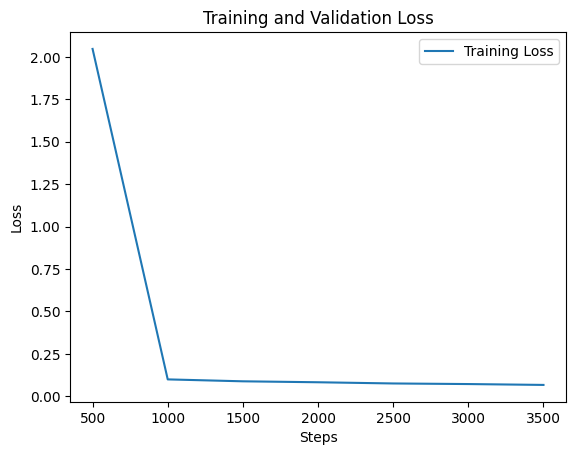

In [14]:
import json
import matplotlib.pyplot as plt

# Load the trainer_state.json
with open(path+'/bart/results/checkpoint-3684/trainer_state.json', 'r') as f:
    trainer_state = json.load(f)

# Extract logs
logs = trainer_state['log_history']

# Separate the values
steps = []
losses = []
eval_losses = []

for log in logs:
    if 'loss' in log:
        steps.append(log['step'])
        losses.append(log['loss'])
    if 'eval_loss' in log:
        eval_losses.append((log['step'], log['eval_loss']))

# Plot training loss
plt.plot(steps, losses, label='Training Loss')
if eval_losses:
    eval_steps, eval_vals = zip(*eval_losses)
    plt.plot(eval_steps, eval_vals, label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [17]:
# from datasets import load_metric
from torch.utils.data import DataLoader

# Load the ROUGE metric for evaluation
rouge = evaluate.load("rouge")

def generate_summaries(model, tokenizer, dataset, batch_size=8):
    """
    Generate summaries using the provided model and tokenizer on the given dataset.

    Args:
        model: The trained summarization model.
        tokenizer: Tokenizer associated with the model.
        dataset: Dataset for which summaries need to be generated.
        batch_size: Number of data samples to process in each batch.

    Returns:
        summaries: Generated summaries by the model.
        references: Actual summaries from the dataset for comparison.
    """
    # Set model to evaluation mode
    model.eval()
    summaries = []    # List to store generated summaries
    references = []   # List to store actual summaries

    # Create a DataLoader for batch processing
    dataloader = DataLoader(dataset, batch_size=batch_size)

    # Disabled gradient calculations for efficiency
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            print(f"Processing {i+1}/{len(dataloader)}")
            # Move input data to the same device as the model
            input_ids = batch['input_ids'].to(model.device)
            attention_mask = batch['attention_mask'].to(model.device)

            # Generate summaries with the model
            outputs = model.generate(input_ids, attention_mask=attention_mask, max_length=2048, num_beams=2)
            batch_summaries = [tokenizer.decode(ids, skip_special_tokens=True) for ids in outputs]

            # Append generated and actual summaries to the respective lists
            summaries.extend(batch_summaries)
            references.extend(batch['summary'])

    return summaries, references

# Generate summaries for the validation dataset
generated_summaries, actual_summaries = generate_summaries(model, tokenizer, valid_dataset, batch_size=8)

# Compute and print the ROUGE score for evaluation
rouge_score = rouge.compute(predictions=generated_summaries, references=actual_summaries)
print(rouge_score)

Processing 1/103
Processing 2/103
Processing 3/103
Processing 4/103
Processing 5/103
Processing 6/103
Processing 7/103
Processing 8/103
Processing 9/103
Processing 10/103
Processing 11/103
Processing 12/103
Processing 13/103
Processing 14/103
Processing 15/103
Processing 16/103
Processing 17/103
Processing 18/103
Processing 19/103
Processing 20/103
Processing 21/103
Processing 22/103
Processing 23/103
Processing 24/103
Processing 25/103
Processing 26/103
Processing 27/103
Processing 28/103
Processing 29/103
Processing 30/103
Processing 31/103
Processing 32/103
Processing 33/103
Processing 34/103
Processing 35/103
Processing 36/103
Processing 37/103
Processing 38/103
Processing 39/103
Processing 40/103
Processing 41/103
Processing 42/103
Processing 43/103
Processing 44/103
Processing 45/103
Processing 46/103
Processing 47/103
Processing 48/103
Processing 49/103
Processing 50/103
Processing 51/103
Processing 52/103
Processing 53/103
Processing 54/103
Processing 55/103
Processing 56/103
P

In [19]:
trainer.evaluate()

{'eval_loss': 0.09247089177370071,
 'eval_runtime': 7.2246,
 'eval_samples_per_second': 113.363,
 'eval_steps_per_second': 7.198,
 'epoch': 10.0}

In [20]:

tokenizer.save_pretrained(path+'/bart-base')
trainer.create_model_card()

# Save the model
trainer.save_model(path+"/bart-base")


In [22]:
# Load fine-tuned BART model using pipeline
summarizer = pipeline("summarization", model=path+'/bart-base')

# Pick a random sample from test data
sample = test_df.iloc[randrange(len(test_df))]
print(f"Dialogue:\n{sample['dialogue']}\n---------------")
print(f"Human Summary:\n{sample['summary']}")

# Generate model summary
res = summarizer(sample["dialogue"], max_length=200, min_length=20, do_sample=False)
print(f"BART Summary:\n{res[0]['summary_text']}")

Device set to use cuda:0


Dialogue:
Lincoln: Heeyyy ;* whats up
Fatima: I talked to Jenson, he’s not too happy ;p
Lincoln: the place sucks??
Fatima: No, the place is ok, I think, we can go there, it’s about Alene
Lincoln: typical, dont worry about it
Fatima: He thinks she may have a depression :[
Lincoln: nothin new, everyone has it, she needs a doctor then
Fatima: But she won’t go ;/
Lincoln: so she’s destroying her life fuck it its not your problem
Fatima: It is, they’re both my friends!
Lincoln: you better think what to do if they break up
Fatima: Ehh yes Ill have a problem ;//
Lincoln: both blaming each other and talking with you about it, perfect
Fatima: Alene is just troubled… She’d been through a lot…
Lincoln: everyone has their problems, the question is are ya doin sth about them
Fatima: She has problems facing it, don’t be surprised :[
Lincoln: then it is her problem
Fatima: You are so cruel at times… o.O
Lincoln: maybe, for me its just a common sense
Fatima: Why can’t everyone be just happy???
Lincoln